# Scenario 2 (High Density)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

## Config

In [2]:
inputFile = '2kr-scalars.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

showConstructedDF = True

# Fitting
distsFit = ['norm', 'uniform'] # Distributions to fit
distsParams = [(), ()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.activityTime:last']
# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('activityTime', 'total broadcast time (residuals)'),
]

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

## Compute residuals

In [6]:
# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# activity (broadcast) time
scalars_wide['activityTimeMean'] = scalars_wide.groupby(factors)['Floorplan.activityTime:last'].transform('mean')
scalars_wide['activityTimeResidual'] = scalars_wide['Floorplan.activityTime:last'] - scalars_wide['activityTimeMean']

## Constructed DataFrame

In [7]:
if showConstructedDF:
    display(scalars_wide.describe())
    display(scalars_wide[(totalSims//2)-10:(totalSims//2)+10])
else:
    print('Skipping...')

qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,Floorplan.activityTime:last,coveredUsersPercent,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,activityTimeMean,activityTimeResidual
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.0,160.000000,160.000000,160.000000,160.000000,160.000000,1.600000e+02,160.000000,1.600000e+02,160.000000,1.600000e+02
mean,7.500000,4.500000,20.000000,3.000000,3.000000,3.000000,500.0,439.793750,876.556250,49.506250,0.881350,0.881350,-3.469447e-18,876.556250,-5.684342e-15,49.506250,2.442491e-16
std,4.624246,2.881299,10.031397,2.006279,2.006279,2.006279,0.0,74.108037,646.827223,39.666851,0.148513,0.098230,1.113871e-01,632.492863,1.354187e+02,37.268826,1.358285e+01
min,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,500.0,22.000000,31.000000,5.000000,0.044088,0.708417,-6.643287e-01,140.500000,-4.152000e+02,9.900000,-7.220000e+01
25%,3.750000,2.000000,10.000000,1.000000,1.000000,1.000000,500.0,416.750000,333.250000,18.000000,0.835170,0.806563,-1.503006e-02,331.900000,-4.085000e+01,23.350000,-3.600000e+00
50%,7.500000,4.500000,20.000000,3.000000,3.000000,3.000000,500.0,460.000000,661.000000,36.000000,0.921844,0.886473,3.607214e-03,692.300000,1.750000e+00,36.500000,-3.000000e-01
75%,11.250000,7.000000,30.000000,5.000000,5.000000,5.000000,500.0,493.000000,1289.500000,61.250000,0.987976,0.973547,4.393788e-02,1274.500000,4.190000e+01,63.400000,2.975000e+00
max,15.000000,9.000000,30.000000,5.000000,5.000000,5.000000,500.0,499.000000,2490.000000,196.000000,1.000000,0.999599,2.194389e-01,2113.200000,3.867000e+02,134.200000,6.690000e+01


qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,Floorplan.activityTime:last,coveredUsersPercent,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,activityTimeMean,activityTimeResidual
run,,,,,,,,,,,,,,,,,
HighDensity2kr-140-20210201-18:16:37-12067,7.0,0.0,10.0,5.0,5.0,5.0,500.0,499.0,418.0,105.0,1.000000,0.999599,0.000401,416.7,1.3,105.4,-0.4
HighDensity2kr-141-20210201-18:16:38-12067,7.0,1.0,10.0,5.0,5.0,5.0,500.0,499.0,438.0,114.0,1.000000,0.999599,0.000401,416.7,21.3,105.4,8.6
HighDensity2kr-142-20210201-18:16:38-12067,7.0,2.0,10.0,5.0,5.0,5.0,500.0,499.0,399.0,99.0,1.000000,0.999599,0.000401,416.7,-17.7,105.4,-6.4
HighDensity2kr-143-20210201-18:16:38-12067,7.0,3.0,10.0,5.0,5.0,5.0,500.0,498.0,448.0,108.0,0.997996,0.999599,-0.001603,416.7,31.3,105.4,2.6
HighDensity2kr-144-20210201-18:16:39-12067,7.0,4.0,10.0,5.0,5.0,5.0,500.0,499.0,443.0,96.0,1.000000,0.999599,0.000401,416.7,26.3,105.4,-9.4
HighDensity2kr-145-20210201-18:16:39-12067,7.0,5.0,10.0,5.0,5.0,5.0,500.0,499.0,372.0,108.0,1.000000,0.999599,0.000401,416.7,-44.7,105.4,2.6
HighDensity2kr-146-20210201-18:16:40-12067,7.0,6.0,10.0,5.0,5.0,5.0,500.0,499.0,414.0,115.0,1.000000,0.999599,0.000401,416.7,-2.7,105.4,9.6
HighDensity2kr-147-20210201-18:16:40-12067,7.0,7.0,10.0,5.0,5.0,5.0,500.0,499.0,440.0,121.0,1.000000,0.999599,0.000401,416.7,23.3,105.4,15.6
HighDensity2kr-148-20210201-18:16:40-12067,7.0,8.0,10.0,5.0,5.0,5.0,500.0,498.0,384.0,104.0,0.997996,0.999599,-0.001603,416.7,-32.7,105.4,-1.4


## Residual distributions (histograms)

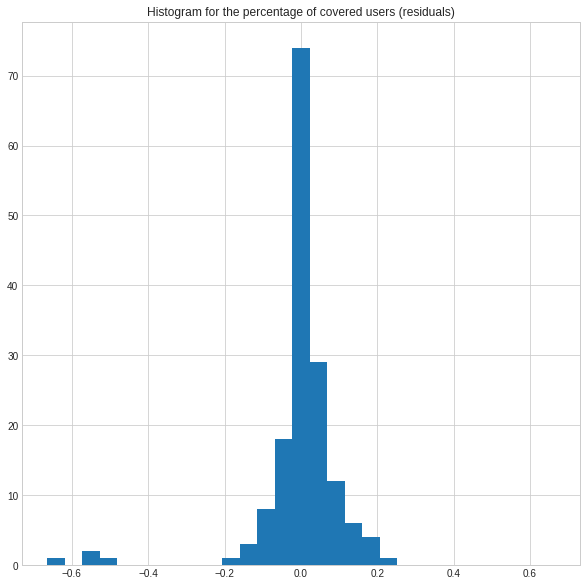

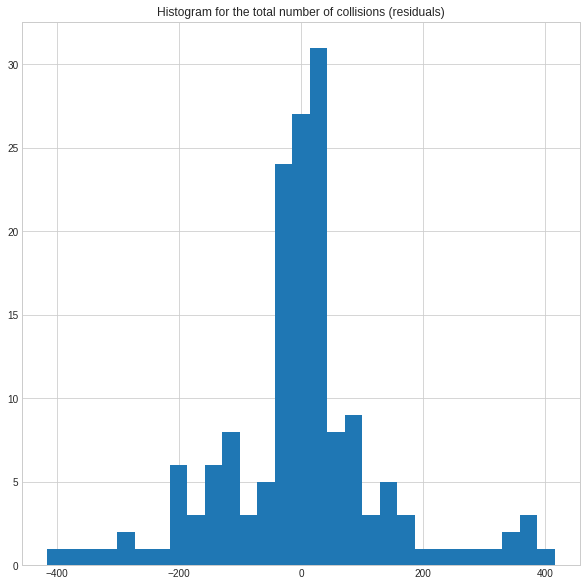

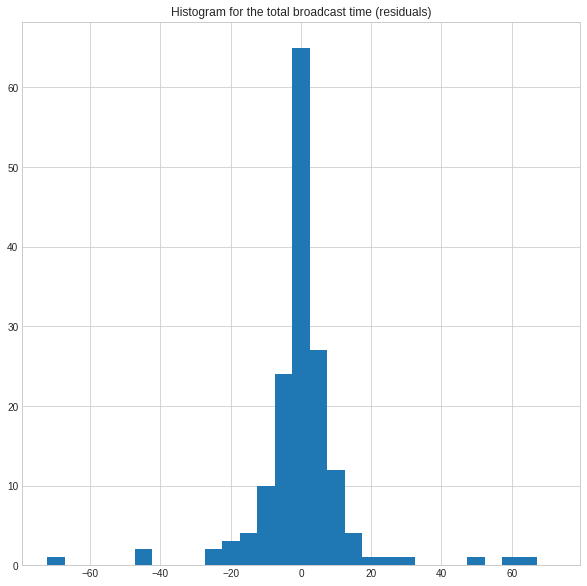

In [8]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-hist.png')
    plt.show()

## Distribution fitting

Trying to fit to a norm distribution:


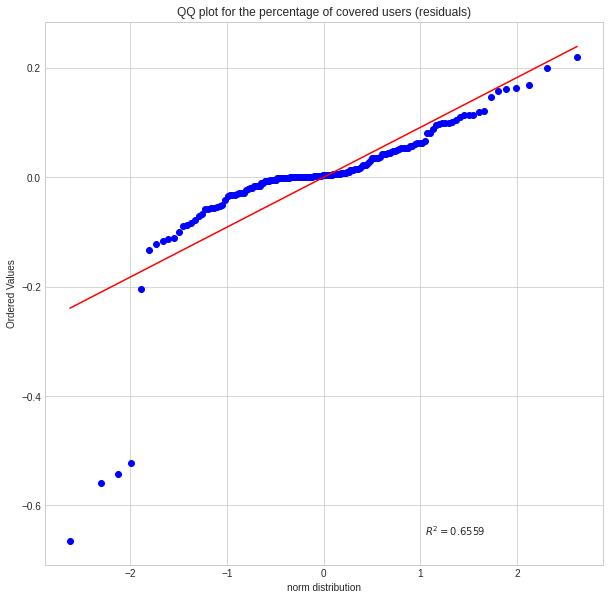

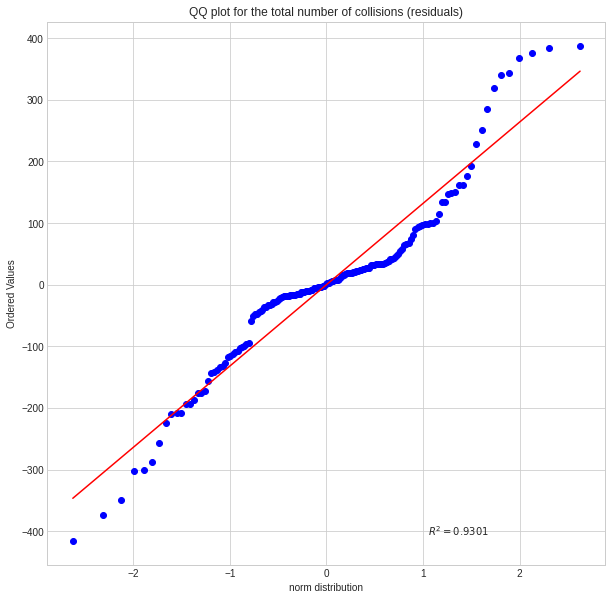

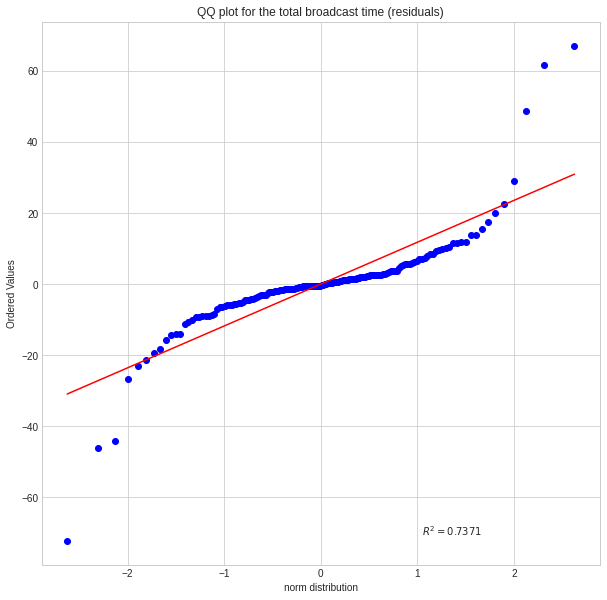

Trying to fit to a uniform distribution:


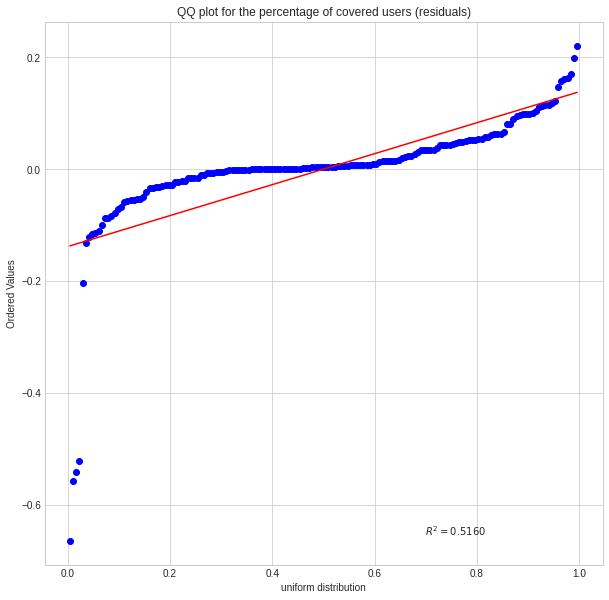

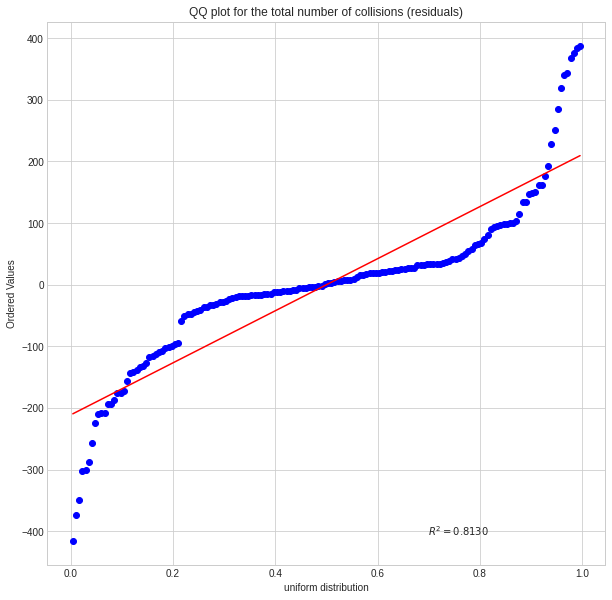

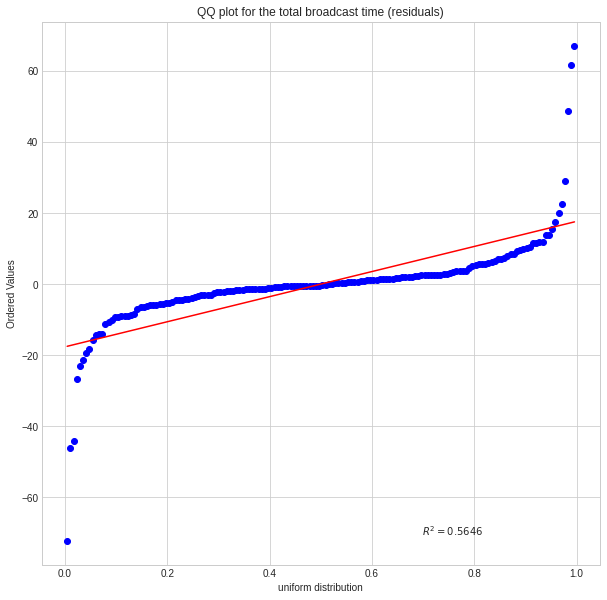

In [9]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + varname + '-' + distribution + '-fit.png')
        plt.show()

### Outliers

In [10]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.8813502004008015
stddev: 0.11138705278963276
3*stddev: 0.33416115836889826


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
HighDensity2kr-7-20210201-18:16:06-12067,0.0,7.0,10.0,1.0,1.0,1.0,-0.522044,0.708417
HighDensity2kr-8-20210201-18:16:06-12067,0.0,8.0,10.0,1.0,1.0,1.0,-0.664329,0.708417
HighDensity2kr-81-20210201-18:16:24-12067,4.0,1.0,10.0,5.0,1.0,1.0,-0.542485,0.809018
HighDensity2kr-120-20210201-18:16:34-12067,5.0,0.0,10.0,5.0,1.0,5.0,-0.558317,0.874950


Outliers for the total number of collisions (residuals)
total mean: 876.5562499999993
stddev: 135.41873796190458
3*stddev: 406.25621388571375


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
HighDensity2kr-38-20210201-18:16:13-12067,10.0,8.0,30.0,1.0,5.0,1.0,-415.2,1599.2


Outliers for the total broadcast time (residuals)
total mean: 49.50624999999988
stddev: 13.582846192599836
3*stddev: 40.74853857779951


qname,config,repetition,R,T,m,D,activityTimeResidual,activityTimeMean
run,,,,,,,,
HighDensity2kr-81-20210201-18:16:24-12067,4.0,1.0,10.0,5.0,1.0,1.0,-46.1,106.1
HighDensity2kr-86-20210201-18:16:25-12067,4.0,6.0,10.0,5.0,1.0,1.0,66.9,106.1
HighDensity2kr-120-20210201-18:16:34-12067,5.0,0.0,10.0,5.0,1.0,5.0,-72.2,134.2
HighDensity2kr-121-20210201-18:16:34-12067,5.0,1.0,10.0,5.0,1.0,5.0,48.8,134.2
HighDensity2kr-122-20210201-18:16:34-12067,5.0,2.0,10.0,5.0,1.0,5.0,61.8,134.2
HighDensity2kr-129-20210201-18:16:36-12067,5.0,9.0,10.0,5.0,1.0,5.0,-44.2,134.2


## Independency test

qname,config,R,T,m,D
run,,,,,
HighDensity2kr-0-20210201-18:16:05-12067,0.0,10.0,1.0,1.0,1.0
HighDensity2kr-40-20210201-18:16:14-12067,1.0,10.0,1.0,1.0,5.0
HighDensity2kr-20-20210201-18:16:07-12067,2.0,10.0,1.0,5.0,1.0
HighDensity2kr-60-20210201-18:16:18-12067,3.0,10.0,1.0,5.0,5.0
HighDensity2kr-80-20210201-18:16:24-12067,4.0,10.0,5.0,1.0,1.0
HighDensity2kr-120-20210201-18:16:34-12067,5.0,10.0,5.0,1.0,5.0
HighDensity2kr-100-20210201-18:16:27-12067,6.0,10.0,5.0,5.0,1.0
HighDensity2kr-140-20210201-18:16:37-12067,7.0,10.0,5.0,5.0,5.0
HighDensity2kr-10-20210201-18:16:06-12067,8.0,30.0,1.0,1.0,1.0


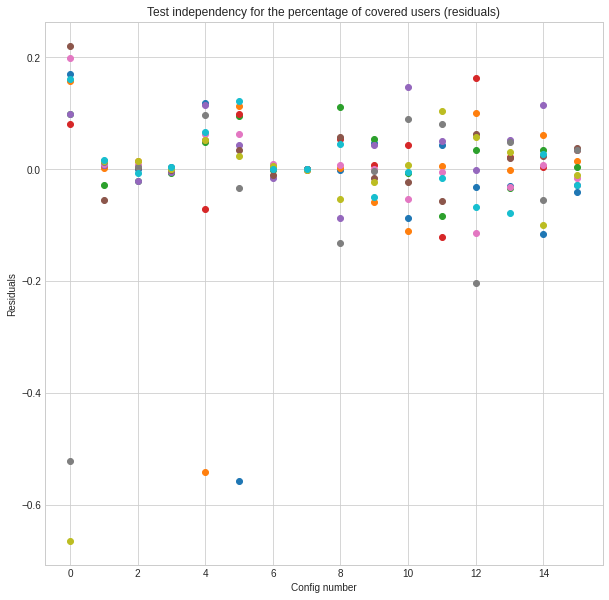

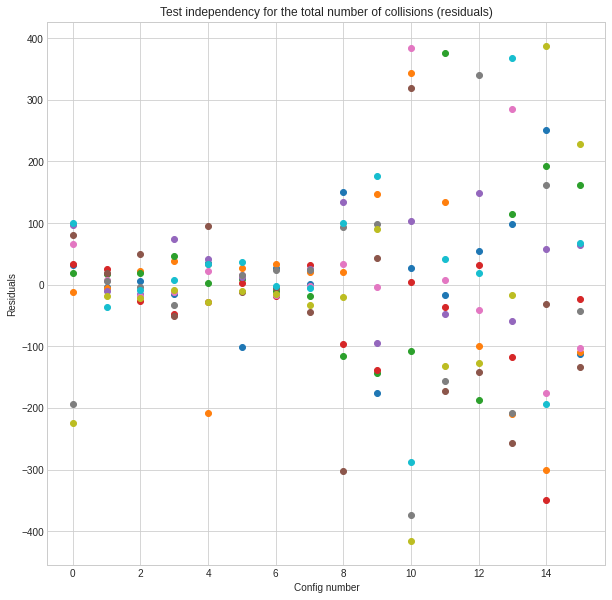

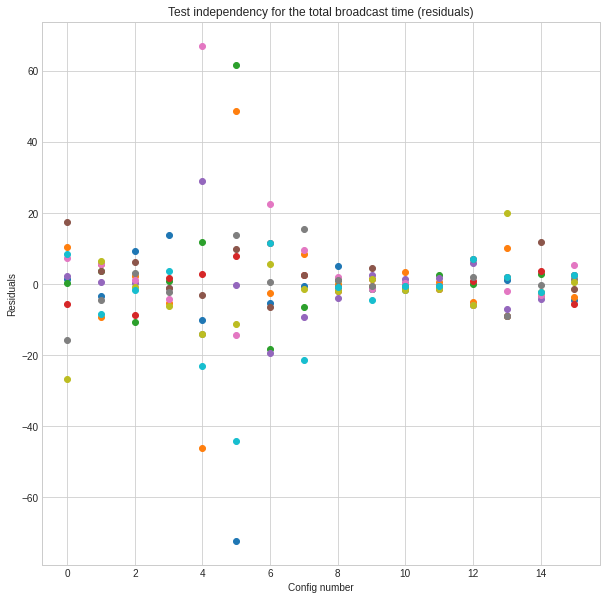

In [11]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-independency.png')
    plt.show()

## Finite variance test

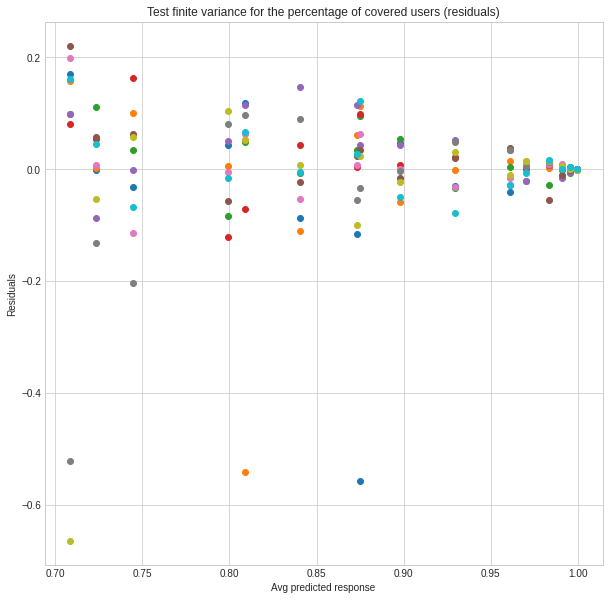

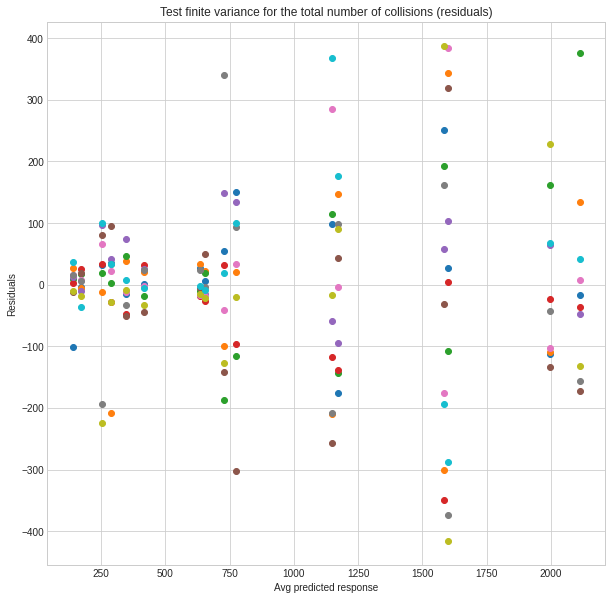

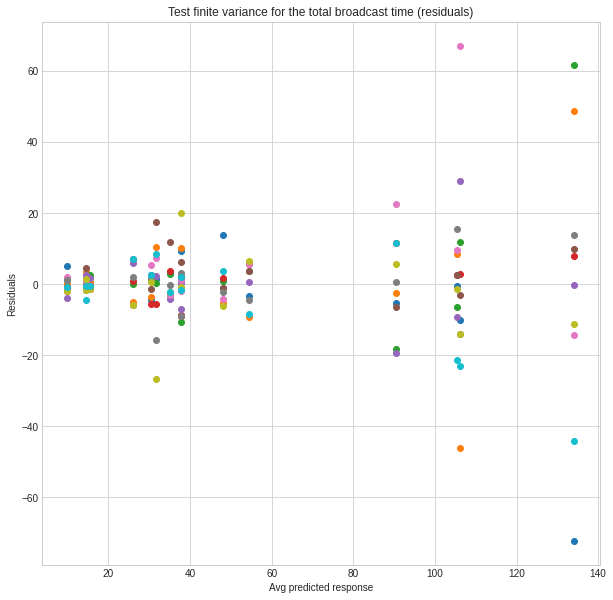

In [12]:
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-variance.png')
    plt.show()